In [ ]:
import os
import pandas as pd
import stat

file_name = "/content/test_synthesize_77.xlsx"
df = pd.read_excel(io=file_name)
print(df.head(5))

    arrival  departure  kWhDelivered VehicleArrivalTime VehicleDepatureTime  \
0  6.273492  13.856324     22.426138           06:16:25            13:51:23   
1  6.283394   8.536122      7.393929           06:17:00            08:32:10   
2  6.356454  10.149326     11.139155           06:21:23            10:08:58   
3  6.472603  17.907040     29.183873           06:28:21            17:54:25   
4  6.503574  10.424525     11.796478           06:30:13            10:25:28   

  Time Required at 3kW Time Required at 7kW Time Required at 11kW  
0             07:28:31             03:12:13              02:02:19  
1             02:27:53             01:03:23              00:40:20  
2             03:42:47             01:35:29              01:00:46  
3             09:43:41             04:10:09              02:39:11  
4             03:55:56             01:41:07              01:04:21  


In [ ]:
def find_min_sum_indexes(k_list, n):
  
    # Find the n smallest variables in the list
    n_smallest = sorted(k_list)[:n]
        
    # Find the indices of the n smallest variables in the original list
    ind = []
    for i in n_smallest:
      ind.append(k_list.index(i))
      k_list[k_list.index(i)] = 0
    
    return sorted(ind)

### **Single kW** 

In [ ]:
from datetime import datetime       #Conversion of data from time format to slot format

data_new = {}
for i in range(len(df)):
  at = datetime.strptime(df['VehicleArrivalTime'][i], '%H:%M:%S').time() 
  dt = datetime.strptime(df['VehicleDepatureTime'][i], '%H:%M:%S').time()
  ctime =  datetime.strptime(df['Time Required at 3kW'][i], '%H:%M:%S').time()
  #Arrival
  temp = (at.minute)%5
  if temp == 0:
    temp_arr = at.minute
  else:
    temp_arr =at.minute+5-temp
  arrival_slot = (at.hour)*12 + (temp_arr/5)
  #Departure
  temp1 = (dt.minute)%5
  temp_dep = dt.minute-temp1
  dept_slot = (dt.hour)*12 + (temp_dep/5)
  #Charging_duration
  temp3 = (ctime.minute)%5
  temp_cd = ctime.minute-temp3
  cd_slot = (ctime.hour)*12 + (temp_cd/5)
  #Create_dict
  data_new[i+1] = {'at':int(arrival_slot),'dt':int(dept_slot),'cd':int(cd_slot)}

Controlled, without PV

In [ ]:
tariff = {0:0.06,1:0.06,2:0.06,3:0.06,4:0.06,5:0.06,6:0.06,7:0.25,8:0.25,9:0.09,10:0.09,11:0.09,12:0.09,13:0.09,14:0.09,15:0.09,16:0.09,17:0.25,18:0.25,19:0.25,20:0.09,21:0.09,22:0.06,23:0.06}

min_slot = {}

rate = 3

cost_per_slot = [] 

for k,v in tariff.items():
  temp = [round((v * rate)/12,5)]*12
  cost_per_slot += temp
cost_per_slot = cost_per_slot*2 

for i in data_new:
    if data_new[i]['dt'] < data_new[i]['at']:
      dt = data_new[i]['dt'] + 288
    else:
      dt = data_new[i]['dt']

    slots = dt - data_new[i]['at']
    cd = data_new[i]['cd']
    slot_tariff = []

    for j in range(data_new[i]['at'], dt):
      slot_tariff.append(cost_per_slot[j])
          
    if cd >= slots:
      min_slot[i] = [x + data_new[i]['at'] for x in range(len(slot_tariff))]
    else: 
      min = find_min_sum_indexes(slot_tariff, cd)
      min_slot[i] = [x + data_new[i]['at'] for x in min]




In [ ]:
from datetime import datetime           #Conversion of data from slot format to time format
final_min_slot = {}

#Convert all slot into minutes
for k,v in min_slot.items():
  time_v = [x*5 for x in v]
  datetime_v = []
  for i in time_v:
    hour = int(i/60)
    min = i%60
    if hour>=24:
      hour = hour - 24
      input_str = '21/06/19 ' + str(hour) + ':' + str(min) + ':00'
      dt_object = datetime.strptime(input_str, '%d/%m/%y %H:%M:%S')
    else:
      input_str = '20/06/19 ' + str(hour) + ':' + str(min) + ':00'
      dt_object = datetime.strptime(input_str, '%d/%m/%y %H:%M:%S')
    datetime_v.append(dt_object)
  final_min_slot[k] = datetime_v

In [ ]:
from datetime import datetime
from datetime import timedelta

input_str = '20/06/19 00:00:00'
dt_object = datetime.strptime(input_str, '%d/%m/%y %H:%M:%S')
n = 5
timestamp = []
for i in range(288):
  final_time = dt_object + timedelta(minutes=i*n)
  timestamp.append(final_time)

In [ ]:
power_uc_wpv = [0]*len(timestamp)     #Calculation of power for uncontrolled charging

vehicle = 16

slots = data_new[vehicle]['dt'] - data_new[vehicle]['at']
cd = data_new[vehicle]['cd']

if slots > cd:
  duration = cd
else:
  duration = slots


for i in range(duration):
  power_uc_wpv[data_new[vehicle]['at']+i] = 3

In [ ]:
power_c_wpv = [0]*len(timestamp)       #Calculation of power for controlled without pv charging

vehicle = 16

for i in final_min_slot[vehicle]:
  if i in timestamp:
    index = timestamp.index(i)
    power_c_wpv[index] = 3

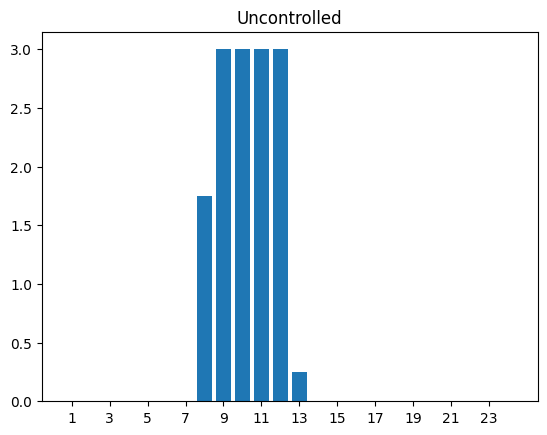

In [ ]:
time = [x+1 for x in range(24)]

import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
#x = np.array(timestamp)
y = np.array(power_uc_wpv)

# Aggregate data into groups of 12
x_grouped = np.array(time)
y_grouped = y.reshape(-1, 12).mean(axis=1)

# Plot the grouped data
plt.bar(x_grouped, y_grouped)

# Set the x-axis tick labels to show only every 12th value
plt.xticks(x_grouped[::2])
plt.title("Uncontrolled")

# Show the plot
plt.show()


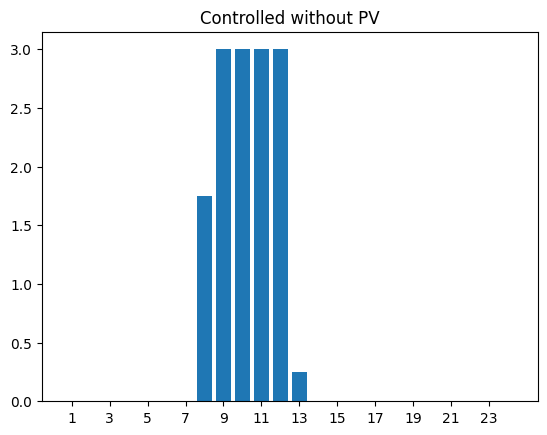

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
#x = np.array(timestamp)
y = np.array(power_c_wpv)

# Aggregate data into groups of 12
x_grouped = np.array(time)
y_grouped = y.reshape(-1, 12).mean(axis=1)

# Plot the grouped data
plt.bar(x_grouped, y_grouped)

# Set the x-axis tick labels to show only every 12th value
plt.xticks(x_grouped[::2])
plt.title("Controlled without PV")

# Show the plot
plt.show()

Controlled, with pv

In [ ]:
# pv_per_hour = {0:0,1:0,2:0,3:0,4:0,5:6.50280763909578,6:15.3312502104903,7:28.0144264428700,8:38.9874810784457,9:46.8373835321062,10:50.4159931388299,11:49.5073555784204,12:43.9171668686913,13:34.7703425648592,14:22.7830336117972,15:9.38161600811833,16:0,17:0,18:0,19:0,20:0,21:0,22:0,23:0}

pv_per_hour = {0:0,1:0,2:0,3:0,4:0,5:4.6204,6:10.8933,7:19.9050,8:27.7016,9:33.2792,10:35.8219,11:35.1763,12:31.2043,13:24.7052,14:16.1879,15:6.6659,16:0,17:0,18:0,19:0,20:0,21:0,22:0,23:0}

pv_per_slot = []
lcoe_pv = 0.08
lcoe_pv_slot = (lcoe_pv/12)*3

tariff = {0:0.06,1:0.06,2:0.06,3:0.06,4:0.06,5:0.06,6:0.06,7:0.25,8:0.25,9:0.09,10:0.09,11:0.09,12:0.09,13:0.09,14:0.09,15:0.09,16:0.09,17:0.25,18:0.25,19:0.25,20:0.09,21:0.09,22:0.06,23:0.06}

rate = 3

cost_per_slot = [] # issue 1 - making it into 5 min slots

for k,v in tariff.items():
  temp = [round((v * rate)/12,5)]*12
  cost_per_slot += temp
cost_per_slot = cost_per_slot*2 # to also contain next day's data(issue 2 resolved)


# for temp in range(2):
for k,v in pv_per_hour.items():
  temp = [v]*12
  pv_per_slot += temp

min_slot_c_pv = {}
# slot_tariff_ev = []
# slot_tariff_pv = []
pv_used = {}


for i in data_new:
    if data_new[i]['dt'] < data_new[i]['at']:
      dt = data_new[i]['dt'] + 288
    else:
      dt = data_new[i]['dt']

    pv_used[i] = []
    slots = dt - data_new[i]['at']
    cd = data_new[i]['cd']
    
    cost_slots = []
    index_chosen = [] # to identify pv slots out of entire one : 0 - ev; 1 - pv

    for j in range(data_new[i]['at'], dt):
      diff = 3 - pv_per_slot[j]
      if diff > 0:
        cost_slots.append(cost_per_slot[j])
        index_chosen.append(0)
      else:
        if lcoe_pv_slot < cost_per_slot[j]:
          cost_slots.append(lcoe_pv_slot)
          index_chosen.append(1)
        else:
          cost_slots.append(cost_per_slot[j])
          index_chosen.append(0)


    if cd >= slots:
      temp = [x + data_new[i]['at'] for x in range(len(cost_slots))]
      
      for j in range(len(index_chosen)):
        if index_chosen[j] == 1:
          pv_per_slot[j + data_new[i]['at']] -= 3
          temp.remove(j + data_new[i]['at'])
          pv_used[i].append(j + data_new[i]['at'])
      
      min_slot_c_pv[i] = temp
      

    else:
      min = find_min_sum_indexes(cost_slots, cd)
      temp = [x + data_new[i]['at'] for x in min]

      for j in min:
        if index_chosen[j] == 1:
          pv_per_slot[j + data_new[i]['at']] -= 3
          temp.remove(j + data_new[i]['at'])
          pv_used[i].append(j + data_new[i]['at'])

      min_slot_c_pv[i] = temp


In [ ]:
from datetime import datetime
final_min_slot_c_pv = {}
final_pv_used = {}

#Convert all slot into minutes for min values
for k,v in min_slot_c_pv.items():
  time_v = [x*5 for x in v]
  datetime_v = []
  for i in time_v:
    hour = int(i/60)
    min = i%60
    if hour>=24:
      hour = hour - 24
      input_str = '21/06/19 ' + str(hour) + ':' + str(min) + ':00'
      dt_object = datetime.strptime(input_str, '%d/%m/%y %H:%M:%S')
    else:
      input_str = '20/06/19 ' + str(hour) + ':' + str(min) + ':00'
      dt_object = datetime.strptime(input_str, '%d/%m/%y %H:%M:%S')
    datetime_v.append(dt_object)
  final_min_slot_c_pv[k] = datetime_v

#Convert all slot into minutes for only pv values
for k,v in pv_used.items():
  time_v = [x*5 for x in v]
  datetime_v = []
  for i in time_v:
    hour = int(i/60)
    min = i%60
    if hour>=24:
      hour = hour - 24
      input_str = '21/06/19 ' + str(hour) + ':' + str(min) + ':00'
      dt_object = datetime.strptime(input_str, '%d/%m/%y %H:%M:%S')
    else:
      input_str = '20/06/19 ' + str(hour) + ':' + str(min) + ':00'
      dt_object = datetime.strptime(input_str, '%d/%m/%y %H:%M:%S')
    datetime_v.append(dt_object)
  final_pv_used[k] = datetime_v

In [ ]:
power_c_pv = [0]*len(timestamp)         #Calculation of power for controlled with PV charging   (grid power)

vehicle = 16

for i in final_min_slot_c_pv[vehicle]:
  if i in timestamp:
    index = timestamp.index(i)
    power_c_pv[index] = 3

In [ ]:
power_c_pv_used = [0]*len(timestamp)        #Calculation of power for controlled with PV charging (solar power)

vehicle = 16

for i in final_pv_used[vehicle]:
  if i in timestamp:
    index = timestamp.index(i)
    power_c_pv_used[index] = 3

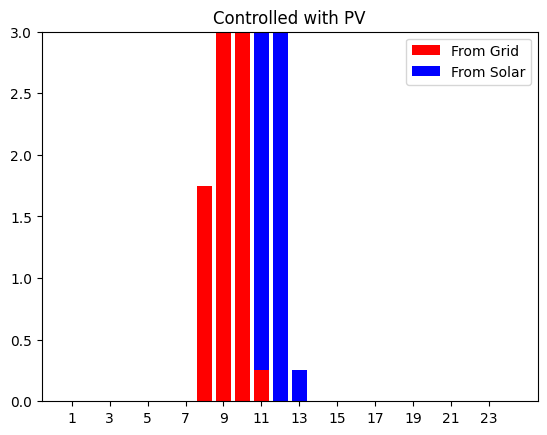

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
#x = np.array(timestamp)
y1 = np.array(power_c_pv)
y2 = np.array(power_c_pv_used)

# Aggregate data into groups of 12
x_grouped = np.array(time)
y_grouped1 = y1.reshape(-1, 12).mean(axis=1)
y_grouped2 = y2.reshape(-1, 12).mean(axis=1)


# Plot the grouped data
plt.bar(x_grouped, y_grouped1, color='r')
plt.bar(x_grouped, y_grouped2, bottom=y_grouped1, color='b')
plt.legend(["From Grid", "From Solar"])

# Set the x-axis tick labels to show only every 12th value
plt.xticks(x_grouped[::2])
plt.yticks([0.0,0.5,1.0,1.5,2.0,2.5,3.0])
plt.title("Controlled with PV")

# Show the plot
plt.show()


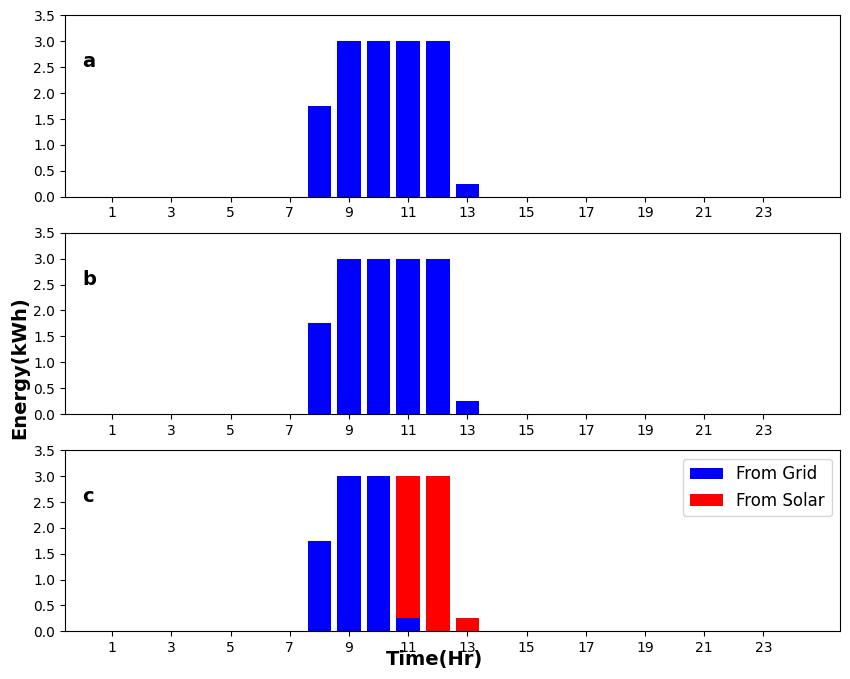

In [ ]:
#######Uncontrolled
time = [x+1 for x in range(24)]

y = np.array(power_uc_wpv)

x_grouped = np.array(time)
y_grouped1 = y.reshape(-1, 12).mean(axis=1)

#######Controlled without pv
y = np.array(power_c_wpv)

y_grouped2 = y.reshape(-1, 12).mean(axis=1)

#######Controlled with pv
y1 = np.array(power_c_pv)
y2 = np.array(power_c_pv_used)

y_grouped3 = y1.reshape(-1, 12).mean(axis=1)
y_grouped4 = y2.reshape(-1, 12).mean(axis=1)

plt.rcParams["figure.figsize"] = [10,8]

plt.subplot(311)
plt.bar(x_grouped, y_grouped1, color='b')
# plt.title("Uncontrolled without PV",fontweight="bold")
plt.xticks(x_grouped[::2])
plt.yticks([0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5])
# plt.ylabel("Power(kW)")
plt.text(0, 2.5, "a", fontsize=14,fontweight="bold")

plt.subplot(312)
plt.bar(x_grouped, y_grouped2, color='b')
# plt.title("Controlled without PV",fontweight="bold")
plt.xticks(x_grouped[::2])
plt.yticks([0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5])
# plt.ylabel("Power(kW)")
plt.text(0, 2.5, "b", fontsize=14,fontweight="bold")

plt.subplot(313)
plt.bar(x_grouped, y_grouped3, color='b')
plt.bar(x_grouped, y_grouped4, bottom=y_grouped3, color='r')
plt.legend(["From Grid", "From Solar"], fontsize=12)
# plt.title("Controlled with PV",fontweight="bold")
plt.xticks(x_grouped[::2])
plt.yticks([0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5])
plt.text(11.9, -0.65, 'Time(Hr)', ha='center', fontsize=14,fontweight="bold")
# plt.xlabel("Time(Hr)")
# plt.ylabel("Power(kW)")
plt.text(0, 2.5, "c", fontsize=14,fontweight="bold")
plt.text(-2.45, 5.1, 'Energy(kWh)', va='center', rotation='vertical', fontsize=14,fontweight="bold")

# Show the plot
plt.show()

(a) Uncontrolled (b) Controlled without PV (c) Controlled with PV for single charging rates.

In [ ]:
#Cost for a single vehicle #9

total_cost_uc_wpv = 0
total_cost_c_wpv = 0
total_cost_c_pv = 0

for i in range(len(power_uc_wpv)):
  if power_uc_wpv[i] > 0:
    total_cost_uc_wpv +=  cost_per_slot[i]

for i in range(len(power_c_wpv)):
  if power_c_wpv[i] > 0:
    total_cost_c_wpv = total_cost_c_wpv + cost_per_slot[i]

for i in range(len(power_c_pv)):
  if power_c_pv[i] > 0:
    total_cost_c_pv = total_cost_c_pv + cost_per_slot[i]

for i in range(len(power_c_pv_used)):
  if power_c_pv_used[i] > 0:
    total_cost_c_pv = total_cost_c_pv + (lcoe_pv/12)*3

print(total_cost_uc_wpv,total_cost_c_wpv,total_cost_c_pv)

2.0199999999999987 2.0199999999999987 1.96


In [ ]:
pv_total = 0          #cost of unused solar power 

for i in range(len(pv_per_slot)):
  if pv_per_slot[i] > 0:
    pv_total += pv_per_slot[i]*0.08/12

print(pv_total)

2.172879999999999


In [ ]:
#Cost for all vehicles

all_cost_uc_wpv = 0
all_cost_c_wpv = 0
all_cost_c_pv = 0

for vehicle in data_new:
  
  power_uc_wpv = [0]*288
  power_c_wpv = [0]*288
  power_c_pv = [0]*288
  power_c_pv_used = [0]*288

  slots = data_new[vehicle]['dt'] - data_new[vehicle]['at']

  if slots > data_new[vehicle]['cd']:
    to_count = data_new[vehicle]['cd']
  else:
    to_count = slots

  for i in range(to_count):
    power_uc_wpv[data_new[vehicle]['at']+i] = 3

  for i in final_min_slot[vehicle]:
    if i in timestamp:
      index = timestamp.index(i)
      power_c_wpv[index] = 3

  for i in final_min_slot_c_pv[vehicle]:
    if i in timestamp:
      index = timestamp.index(i)
      power_c_pv[index] = 3

  for i in final_pv_used[vehicle]:
    if i in timestamp:
      index = timestamp.index(i)
      power_c_pv_used[index] = 3

  for i in range(len(power_uc_wpv)):
    if power_uc_wpv[i] > 0:
      all_cost_uc_wpv +=  cost_per_slot[i]

  for i in range(len(power_c_wpv)):
    if power_c_wpv[i] > 0:
      all_cost_c_wpv +=  cost_per_slot[i]

  for i in range(len(power_c_pv)):
    if power_c_pv[i] > 0:
      all_cost_c_pv += cost_per_slot[i]

  for i in range(len(power_c_pv_used)):
    if power_c_pv_used[i] > 0:
      all_cost_c_pv += (lcoe_pv/12)*3

print(f'UC_WPV : {all_cost_uc_wpv}, C_WPV : {all_cost_c_wpv}, C_PV : {all_cost_c_pv}, Solar profit from grid : {pv_total}, Overall_cost : {all_cost_c_pv-pv_total}')

UC_WPV : 137.25749999999172, C_WPV : 124.07999999999194, C_PV : 115.36999999999328, Solar profit from grid : 2.172879999999999, Overall_cost : 113.19711999999329


### **Multiple kW** 

In [ ]:
data_new_upd = {}                                                                 ###Conversion of data from time format to slot format
for i in range(len(df)):
  at = datetime.strptime(df['VehicleArrivalTime'][i], '%H:%M:%S').time() 
  dt = datetime.strptime(df['VehicleDepatureTime'][i], '%H:%M:%S').time()
  #Arrival
  temp = (at.minute)%5
  if temp == 0:
    temp_arr = at.minute
  else:
    temp_arr = at.minute+5-temp
  arrival_slot = (at.hour)*12 + (temp_arr/5)
  #Departure
  temp1 = (dt.minute)%5
  temp_dep = dt.minute-temp1
  dept_slot = (dt.hour)*12 + (temp_dep/5)
  #Charging_duration
  ctime3 =  datetime.strptime(df['Time Required at 3kW'][i], '%H:%M:%S').time()
  temp3 = (ctime3.minute)%5
  temp_cd3 = ctime3.minute-temp3
  cd_slot3 = (ctime3.hour)*12 + (temp_cd3/5)

  ctime7 =  datetime.strptime(df['Time Required at 7kW'][i], '%H:%M:%S').time()
  temp7 = (ctime7.minute)%5
  temp_cd7 = ctime7.minute-temp7
  cd_slot7 = (ctime7.hour)*12 + (temp_cd7/5)

  ctime11 =  datetime.strptime(df['Time Required at 11kW'][i], '%H:%M:%S').time()
  temp11 = (ctime11.minute)%5
  temp_cd11 = ctime11.minute-temp11
  cd_slot11 = (ctime11.hour)*12 + (temp_cd11/5)

  #Create_dict
  data_new_upd[i+1] = {'at':int(arrival_slot),'dt':int(dept_slot),'cd':{3:int(cd_slot3),7:int(cd_slot7),11:int(cd_slot11)}}


In [ ]:
data_new_upd

{1: {'at': 76, 'dt': 166, 'cd': {3: 89, 7: 38, 11: 24}},
 2: {'at': 76, 'dt': 102, 'cd': {3: 29, 7: 12, 11: 8}},
 3: {'at': 77, 'dt': 121, 'cd': {3: 44, 7: 19, 11: 12}},
 4: {'at': 78, 'dt': 214, 'cd': {3: 116, 7: 50, 11: 31}},
 5: {'at': 78, 'dt': 125, 'cd': {3: 47, 7: 20, 11: 12}},
 6: {'at': 78, 'dt': 122, 'cd': {3: 56, 7: 24, 11: 15}},
 7: {'at': 81, 'dt': 184, 'cd': {3: 150, 7: 64, 11: 40}},
 8: {'at': 82, 'dt': 116, 'cd': {3: 41, 7: 17, 11: 11}},
 9: {'at': 82, 'dt': 109, 'cd': {3: 35, 7: 15, 11: 9}},
 10: {'at': 83, 'dt': 168, 'cd': {3: 32, 7: 13, 11: 8}},
 11: {'at': 85, 'dt': 194, 'cd': {3: 12, 7: 5, 11: 3}},
 12: {'at': 86, 'dt': 241, 'cd': {3: 243, 7: 104, 11: 66}},
 13: {'at': 87, 'dt': 210, 'cd': {3: 75, 7: 32, 11: 20}},
 14: {'at': 88, 'dt': 178, 'cd': {3: 23, 7: 10, 11: 6}},
 15: {'at': 88, 'dt': 159, 'cd': {3: 62, 7: 26, 11: 16}},
 16: {'at': 89, 'dt': 145, 'cd': {3: 105, 7: 45, 11: 28}},
 17: {'at': 89, 'dt': 108, 'cd': {3: 267, 7: 114, 11: 73}},
 18: {'at': 89, 'dt': 

In [ ]:
tariff = {0:0.06,1:0.06,2:0.06,3:0.06,4:0.06,5:0.06,6:0.06,7:0.25,8:0.25,9:0.09,10:0.09,11:0.09,12:0.09,13:0.09,14:0.09,15:0.09,16:0.09,17:0.25,18:0.25,19:0.25,20:0.09,21:0.09,22:0.06,23:0.06}

min_slot = {}

cost_per_slot = {3:[],7:[],11:[]} 

for rate in cost_per_slot:
  for k,v in tariff.items():
    temp = [round((v * rate)/12,5)]*12
    cost_per_slot[rate] += temp


In [ ]:
def find_min_sum_indexes(k_list, n):
    
    # Find the n smallest variables in the list
    n_smallest = sorted(k_list)[:n]
    
    # Find the sum of the n smallest variables
    sum_of_n_variables = sum(n_smallest)
    
    # Find the indices of the n smallest variables in the original list
    ind = []
    for i in n_smallest:
      ind.append(k_list.index(i))
      k_list[k_list.index(i)] = 0
    
    return sorted(ind)

    
def remove_old(charging, arrival):      # fn to remove departured cars and update the count
  for i in charging:
    temp = sorted(charging[i]['avail'])
    for j in sorted(charging[i]['avail']):
      if arrival >= j:
        temp.pop(0)
        charging[i]['count'] += 1
      else:
        break
    charging[i]['avail'] = temp
  
  return charging

def add_new(charging, data_new_upd, vehicle, dt):   # fn to add new vehicles and find their appropriate charging rate 
  slots = dt - data_new_upd[vehicle]['at']
  for i in charging:
    cd = data_new_upd[vehicle]['cd'][i]

    if charging[i]['count'] > 0 and cd < slots: # edit to new one - even though cd doesn't match, if there is station, use it
      curr_rate = i
      break
    elif charging[i]['count'] > 0:
      curr_rate = i

  charging[curr_rate]['count'] -= 1
  charging[curr_rate]['avail'].append(dt)
  return charging, curr_rate, slots, cd

Uncontrolled

In [ ]:
charging = {3:{'count':30,'avail':[]},7:{'count':20,'avail':[]},11:{'count':10,'avail':[]}}

min_slot_uc_wpv_diff_rates_m = {}
rate = 3

for i in data_new_upd:
    if data_new_upd[i]['dt'] < data_new_upd[i]['at']:
      dt = data_new_upd[i]['dt'] + 288
    else:
      dt = data_new_upd[i]['dt']

    charging = remove_old(charging, data_new_upd[i]['at']) 
    charging, rate, slots, cd = add_new(charging, data_new_upd, i, dt)
    
    cost_slots = []
    index_chosen = [] # to identify pv slots out of entire one : 0 - ev; 1 - pv

    if cd >= slots:
      temp = [x + data_new_upd[i]['at'] for x in range(slots)]
      
    else:
      min = [x for x in range(cd)]
      temp = [x + data_new_upd[i]['at'] for x in min]

    min_slot_uc_wpv_diff_rates_m[i] = {'rate':rate,'values':temp}


In [ ]:
from datetime import datetime                                   ###Conversion from slot format to time format
final_min_slot_uc_wpv_diff_rates_m = {}

#Convert all slot into minutes for min values
for k,v in min_slot_uc_wpv_diff_rates_m.items():
  time_v = [x*5 for x in v['values']]
  datetime_v = []
  for i in time_v:
    hour = int(i/60)
    min = i%60
    if hour>=24:
      hour = hour - 24
      input_str = '21/06/19 ' + str(hour) + ':' + str(min) + ':00'
      dt_object = datetime.strptime(input_str, '%d/%m/%y %H:%M:%S')
    else:
      input_str = '20/06/19 ' + str(hour) + ':' + str(min) + ':00'
      dt_object = datetime.strptime(input_str, '%d/%m/%y %H:%M:%S')
    datetime_v.append(dt_object)
  final_min_slot_uc_wpv_diff_rates_m[k] = datetime_v


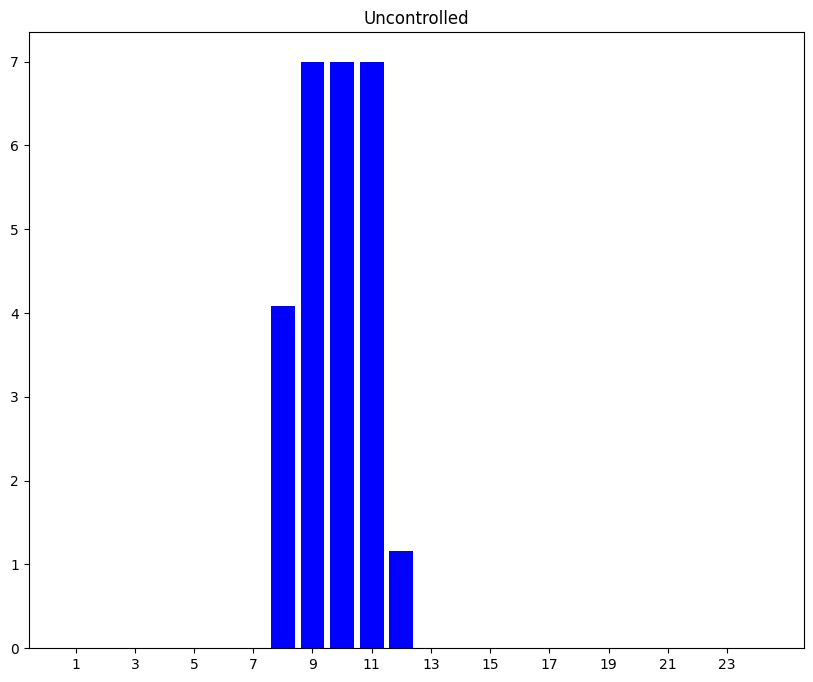

In [ ]:
power_uc_wpv_m = [0]*len(timestamp)                               #Calculation of power for uncontrolled charging

vehicle = 16

for i in final_min_slot_uc_wpv_diff_rates_m[vehicle]:
  if i in timestamp:
    index = timestamp.index(i)
    power_uc_wpv_m[index] = min_slot_uc_wpv_diff_rates_m[vehicle]['rate']


import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
#x = np.array(timestamp)
y1 = np.array(power_uc_wpv_m)

# Aggregate data into groups of 12
x_grouped = np.array(time)
y_grouped1 = y1.reshape(-1, 12).mean(axis=1)


# Plot the grouped data
plt.bar(x_grouped, y_grouped1, color='r')
plt.bar(x_grouped, y_grouped1, color='b')

# Set the x-axis tick labels to show only every 12th value
plt.xticks(x_grouped[::2])
# plt.yticks([0.0,0.5,1.0,1.5,2.0,2.5,3.0])
plt.title("Uncontrolled")

# Show the plot
plt.show()

Controlled without PV

In [ ]:
charging = {3:{'count':30,'avail':[]},7:{'count':20,'avail':[]},11:{'count':10,'avail':[]}}
pv_per_hour_new = {key:0 for key in range(24)}
pv_per_slot = []
lcoe_pv = 0.08
lcoe_pv_slot = lcoe_pv/12


for temp in range(2):
  for k,v in pv_per_hour_new.items():
    temp = [v]*12
    pv_per_slot += temp

min_slot_c_wpv_diff_rates_m = {}
slot_tariff_ev = []
slot_tariff_pv = []
pv_used = {}
rate = 3

for i in data_new_upd:
    if data_new_upd[i]['dt'] < data_new_upd[i]['at']:
      dt = data_new_upd[i]['dt'] + 288
    else:
      dt = data_new_upd[i]['dt']

    pv_used[i] = []

    charging = remove_old(charging, data_new_upd[i]['at']) 
    charging, rate, slots, cd = add_new(charging, data_new_upd, i, dt)
    
    cost_slots = []
    index_chosen = [] # to identify pv slots out of entire one : 0 - ev; 1 - pv

    for j in range(data_new[i]['at'], dt):
      diff = rate - pv_per_slot[j]
      if diff > 0:
        cost_slots.append(cost_per_slot[rate][j])
        index_chosen.append(0)
      else:
        if lcoe_pv_slot*rate < cost_per_slot[rate][j]:
          cost_slots.append(lcoe_pv_slot*rate)
          index_chosen.append(1)
        else:
          cost_slots.append(cost_per_slot[rate][j])
          index_chosen.append(0)

    if cd >= slots:
      temp = [x + data_new_upd[i]['at'] for x in range(len(cost_slots))]
      
      for j in range(len(index_chosen)):
        if index_chosen[j] == 1:
          pv_per_slot[j + data_new_upd[i]['at']] -= rate
          temp.remove(j + data_new_upd[i]['at'])
          pv_used[i].append(j + data_new_upd[i]['at'])

    else:
      min = find_min_sum_indexes(cost_slots, cd)
      for j in min:
        if index_chosen[j] == 1:
          pv_per_slot[j + data_new_upd[i]['at']] -= rate
          min.remove(j)
          pv_used[i].append(j + data_new_upd[i]['at'])

      temp = [x + data_new_upd[i]['at'] for x in min]

    min_slot_c_wpv_diff_rates_m[i] = {'rate':rate,'values':temp}


In [ ]:
from datetime import datetime                             
final_min_slot_c_wpv_diff_rates_m = {}
final_pv_used_diff_rates_m = {}

#Convert all slot into minutes for min values
for k,v in min_slot_c_wpv_diff_rates_m.items():
  time_v = [x*5 for x in v['values']]
  datetime_v = []
  for i in time_v:
    hour = int(i/60)
    min = i%60
    if hour>=24:
      hour = hour - 24
      input_str = '21/06/19 ' + str(hour) + ':' + str(min) + ':00'
      dt_object = datetime.strptime(input_str, '%d/%m/%y %H:%M:%S')
    else:
      input_str = '20/06/19 ' + str(hour) + ':' + str(min) + ':00'
      dt_object = datetime.strptime(input_str, '%d/%m/%y %H:%M:%S')
    datetime_v.append(dt_object)
  final_min_slot_c_wpv_diff_rates_m[k] = datetime_v

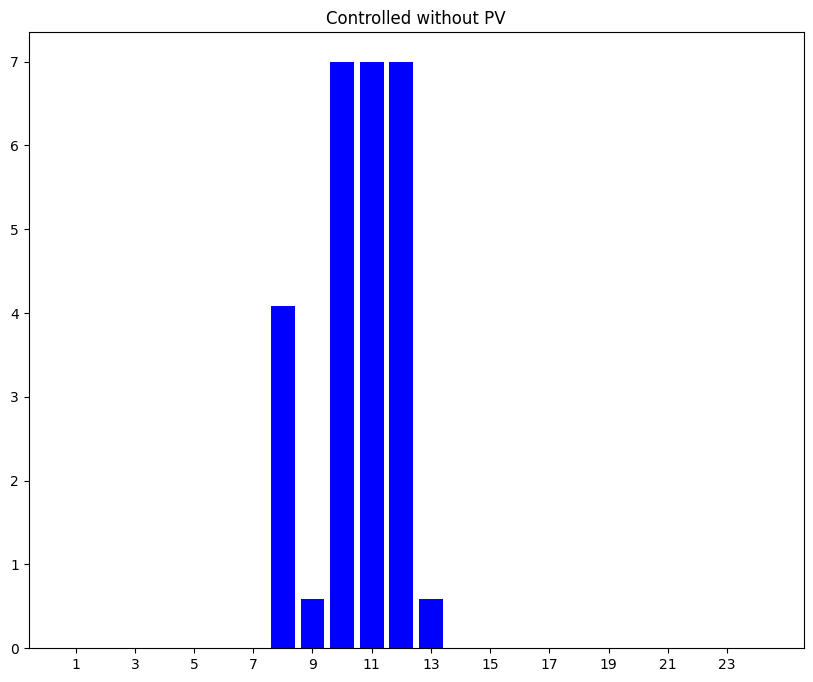

In [ ]:
power_c_wpv_m = [0]*len(timestamp)                    #Calculation of power for controlled without PV charging

vehicle = 16

for i in final_min_slot_c_wpv_diff_rates_m[vehicle]:
  if i in timestamp:
    index = timestamp.index(i)
    power_c_wpv_m[index] = min_slot_c_wpv_diff_rates_m[vehicle]['rate']


import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
y1 = np.array(power_c_wpv_m)

# Aggregate data into groups of 12
x_grouped = np.array(time)
y_grouped1 = y1.reshape(-1, 12).mean(axis=1)


# Plot the grouped data
plt.bar(x_grouped, y_grouped1, color='r')
plt.bar(x_grouped, y_grouped1, color='b')

# Set the x-axis tick labels to show only every 12th value
plt.xticks(x_grouped[::2])
plt.yticks([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0])
plt.title("Controlled without PV")

# Show the plot
plt.show()

Controlled with PV

In [ ]:
charging = {3:{'count':30,'avail':[]},7:{'count':20,'avail':[]},11:{'count':10,'avail':[]}}
# pv_per_hour = {0:0,1:0,2:0,3:0,4:0,5:6.50280763909578,6:15.3312502104903,7:28.0144264428700,8:38.9874810784457,9:46.8373835321062,10:50.4159931388299,11:49.5073555784204,12:43.9171668686913,13:34.7703425648592,14:22.7830336117972,15:9.38161600811833,16:0,17:0,18:0,19:0,20:0,21:0,22:0,23:0}

pv_per_hour = {0:0,1:0,2:0,3:0,4:0,5:4.6204,6:10.8933,7:19.9050,8:27.7016,9:33.2792,10:35.8219,11:35.1763,12:31.2043,13:24.7052,14:16.1879,15:6.6659,16:0,17:0,18:0,19:0,20:0,21:0,22:0,23:0}

pv_per_slot = []
lcoe_pv = 0.08
lcoe_pv_slot = lcoe_pv/12


# for temp in range(2):
for k,v in pv_per_hour.items():
  temp = [v]*12
  pv_per_slot += temp

min_slot_c_pv_diff_rates = {}
slot_tariff_ev = []
slot_tariff_pv = []
pv_used = {}
rate = 3

for i in data_new_upd:
    if data_new_upd[i]['dt'] < data_new_upd[i]['at']:
      dt = data_new_upd[i]['dt'] + 288
    else:
      dt = data_new_upd[i]['dt']

    pv_used[i] = []

    charging = remove_old(charging, data_new_upd[i]['at']) 
    charging, rate, slots, cd = add_new(charging, data_new_upd, i, dt)
    
    cost_slots = []
    index_chosen = [] # to identify pv slots out of entire one : 0 - ev; 1 - pv


    for j in range(data_new_upd[i]['at'], dt):
      diff = rate - pv_per_slot[j]
      if diff > 0:
        cost_slots.append(cost_per_slot[rate][j])
        index_chosen.append(0)
      else:
        if lcoe_pv_slot*rate < cost_per_slot[rate][j]:
          cost_slots.append(lcoe_pv_slot*rate)
          index_chosen.append(1)
        else:
          cost_slots.append(cost_per_slot[rate][j])
          index_chosen.append(0)


    if cd >= slots:
      temp = [x + data_new_upd[i]['at'] for x in range(len(cost_slots))]
      
      for j in range(len(index_chosen)):
        if index_chosen[j] == 1:
          pv_per_slot[j + data_new_upd[i]['at']] -= rate
          temp.remove(j + data_new_upd[i]['at'])
          pv_used[i].append(j + data_new_upd[i]['at'])

    else:
      min = find_min_sum_indexes(cost_slots, cd)
      temp = [x + data_new_upd[i]['at'] for x in min]

      for j in min:
        if index_chosen[j] == 1:
          pv_per_slot[j + data_new_upd[i]['at']] -= rate
          temp.remove(j + data_new_upd[i]['at'])
          pv_used[i].append(j + data_new_upd[i]['at'])

    min_slot_c_pv_diff_rates[i] = {'rate':rate,'values':temp}


In [ ]:
from datetime import datetime
final_min_slot_c_pv_diff_rates_m = {}
final_pv_used_diff_rates_m = {}

#Convert all slot into minutes for min values
for k,v in min_slot_c_pv_diff_rates.items():
  time_v = [x*5 for x in v['values']]
  datetime_v = []
  for i in time_v:
    hour = int(i/60)
    min = i%60
    if hour>=24:
      hour = hour - 24
      input_str = '21/06/19 ' + str(hour) + ':' + str(min) + ':00'
      dt_object = datetime.strptime(input_str, '%d/%m/%y %H:%M:%S')
    else:
      input_str = '20/06/19 ' + str(hour) + ':' + str(min) + ':00'
      dt_object = datetime.strptime(input_str, '%d/%m/%y %H:%M:%S')
    datetime_v.append(dt_object)
  final_min_slot_c_pv_diff_rates_m[k] = datetime_v

#Convert all slot into minutes for only pv values
for k,v in pv_used.items():
  time_v = [x*5 for x in v]
  datetime_v = []
  for i in time_v:
    hour = int(i/60)
    min = i%60
    if hour>=24:
      hour = hour - 24
      input_str = '21/06/19 ' + str(hour) + ':' + str(min) + ':00'
      dt_object = datetime.strptime(input_str, '%d/%m/%y %H:%M:%S')
    else:
      input_str = '20/06/19 ' + str(hour) + ':' + str(min) + ':00'
      dt_object = datetime.strptime(input_str, '%d/%m/%y %H:%M:%S')
    datetime_v.append(dt_object)
  final_pv_used_diff_rates_m[k] = datetime_v

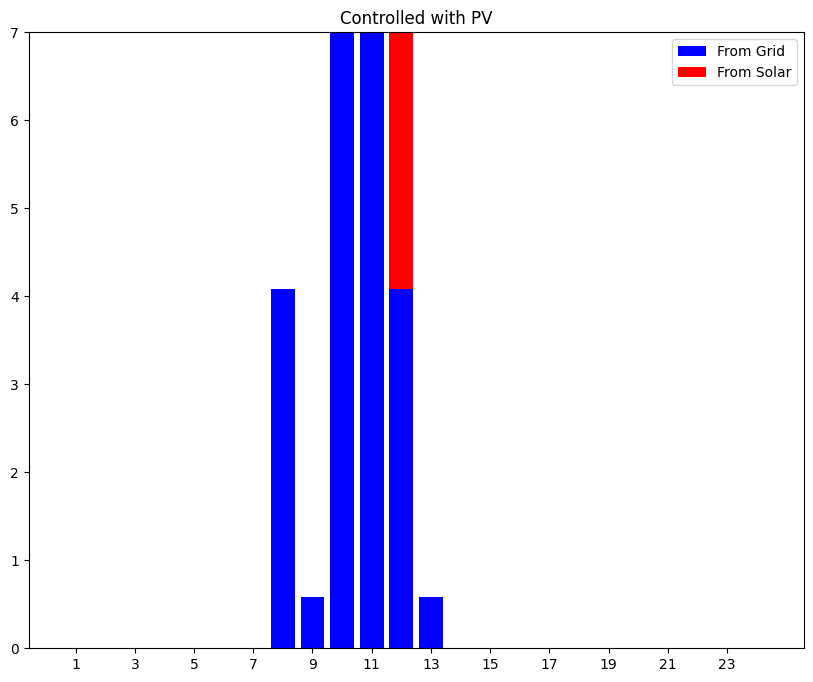

In [ ]:
power_c_pv_m = [0]*len(timestamp)                         #Calculation of power for controlled with pv charging

vehicle = 16

for i in final_min_slot_c_pv_diff_rates_m[vehicle]:
  if i in timestamp:
    index = timestamp.index(i)
    power_c_pv_m[index] = min_slot_c_pv_diff_rates[vehicle]['rate']


power_c_pv_used_m = [0]*len(timestamp)

for i in final_pv_used_diff_rates_m[vehicle]:
  if i in timestamp:
    index = timestamp.index(i)
    power_c_pv_used_m[index] = min_slot_c_pv_diff_rates[vehicle]['rate']

import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
#x = np.array(timestamp)
y1 = np.array(power_c_pv_m)
y2 = np.array(power_c_pv_used_m)

# Aggregate data into groups of 12
x_grouped = np.array(time)
y_grouped1 = y1.reshape(-1, 12).mean(axis=1)
y_grouped2 = y2.reshape(-1, 12).mean(axis=1)


# Plot the grouped data
plt.bar(x_grouped, y_grouped1, color='b')
plt.bar(x_grouped, y_grouped2, bottom=y_grouped1, color='r')
plt.legend(["From Grid", "From Solar"])

# Set the x-axis tick labels to show only every 12th value
plt.xticks(x_grouped[::2])
plt.yticks([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0])
# plt.yticks([0.0,0.5,1.0,1.5,2.0,2.5,3.0])
plt.title("Controlled with PV")

# Show the plot
plt.show()

<ipython-input-34-9872aadfcd40>:30: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(311)


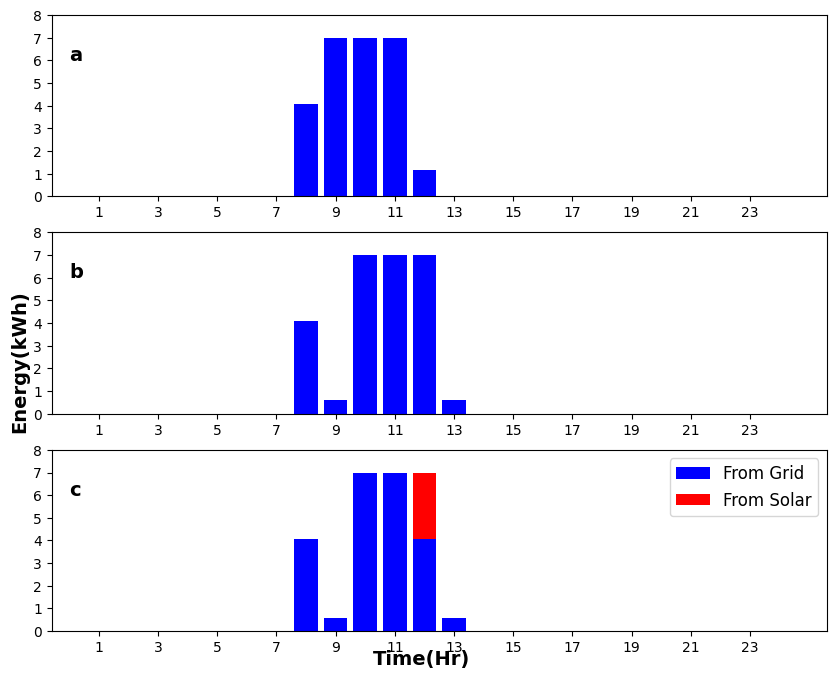

In [ ]:
#######Uncontrolled
y1 = np.array(power_uc_wpv_m)
x_grouped = np.array(time)
y_grouped1 = y1.reshape(-1, 12).mean(axis=1)


plt.xticks(x_grouped[::2])
# plt.yticks([0.0,0.5,1.0,1.5,2.0,2.5,3.0])
plt.title("Uncontrolled without PV")

#######Controlled without pv
y2 = np.array(power_c_wpv_m)

# Aggregate data into groups of 12
x_grouped = np.array(time)
y_grouped2 = y2.reshape(-1, 12).mean(axis=1)


#######Controlled with pv
y3 = np.array(power_c_pv_m)
y4 = np.array(power_c_pv_used_m)

# Aggregate data into groups of 12
x_grouped = np.array(time)
y_grouped3 = y3.reshape(-1, 12).mean(axis=1)
y_grouped4 = y4.reshape(-1, 12).mean(axis=1)

########################################plt.rcParams["figure.figsize"] = [12,10]

plt.subplot(311)
plt.bar(x_grouped, y_grouped1, color='b')
# plt.title("Uncontrolled without PV",fontweight="bold")
plt.xticks(x_grouped[::2])
plt.yticks([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0])
# plt.ylabel("Power(kW)")
plt.text(0, 6, "a", fontsize=14,fontweight="bold")

plt.subplot(312)
plt.bar(x_grouped, y_grouped2, color='b')
# plt.title("Controlled without PV",fontweight="bold")
plt.xticks(x_grouped[::2])
plt.yticks([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0])
# plt.ylabel("Power(kW)")
plt.text(0, 6, "b", fontsize=14,fontweight="bold")

plt.subplot(313)
plt.bar(x_grouped, y_grouped3, color='b')
plt.bar(x_grouped, y_grouped4, bottom=y_grouped3, color='r')
plt.legend(["From Grid", "From Solar"], fontsize=12)
# plt.title("Controlled with PV",fontweight="bold")
plt.xticks(x_grouped[::2])
plt.yticks([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0])
plt.text(11.9, -1.5, 'Time(Hr)', ha='center', fontsize=14,fontweight="bold")
# plt.xlabel("Time(Hr)")
# plt.ylabel("Power(kW)")
plt.text(0, 6, "c", fontsize=14,fontweight="bold")
plt.text(-2, 11.9, 'Energy(kWh)', va='center', rotation='vertical', fontsize=14,fontweight="bold")



# Show the plot
plt.show()

(a) Uncontrolled (b) Controlled without PV (c) Controlled with PV for Multiple charging rates.

In [ ]:
#Cost for a single vehicle #7

total_cost_uc_wpv_m = 0
total_cost_c_wpv_m = 0
total_cost_c_pv_m = 0

for i in range(len(power_uc_wpv_m)):
  if power_uc_wpv_m[i] > 0:
    total_cost_uc_wpv_m +=  cost_per_slot[7][i]

for i in range(len(power_c_wpv_m)):
  if power_c_wpv_m[i] > 0:
    total_cost_c_wpv_m += cost_per_slot[7][i]

for i in range(len(power_c_pv_m)):
  if power_c_pv_m[i] > 0:
    total_cost_c_pv_m += cost_per_slot[7][i]

for i in range(len(power_c_pv_used_m)):
  if power_c_pv_used_m[i] > 0:
    total_cost_c_pv_m += (0.08/12)*7

print(total_cost_uc_wpv_m,total_cost_c_wpv_m,total_cost_c_pv_m)

4.135770000000005 3.1091400000000045 3.0799733333333377


In [ ]:
pv_total_m = 0

for i in range(len(pv_per_slot)):
  if pv_per_slot[i] > 0:
    pv_total_m += pv_per_slot[i]*0.08/12

print(pv_total_m)

2.072880000000004


In [ ]:
#Cost for all vehicles

all_cost_uc_wpv_m = 0
all_cost_c_wpv_m = 0
all_cost_c_pv_m = 0

for vehicle in data_new_upd:
  
  power_uc_wpv_m = [0]*288
  power_c_wpv_m = [0]*288
  power_c_pv_m = [0]*288
  power_c_pv_used_m = [0]*288

  rate1 = min_slot_uc_wpv_diff_rates_m[vehicle]['rate']
  rate2 = min_slot_c_wpv_diff_rates_m[vehicle]['rate']
  rate3 = min_slot_c_pv_diff_rates[vehicle]['rate']


  for i in final_min_slot_uc_wpv_diff_rates_m[vehicle]:
    if i in timestamp:
      index = timestamp.index(i)
      power_uc_wpv_m[index] = min_slot_uc_wpv_diff_rates_m[vehicle]['rate']

  for i in final_min_slot_c_wpv_diff_rates_m[vehicle]:
    if i in timestamp:
      index = timestamp.index(i)
      power_c_wpv_m[index] = min_slot_c_wpv_diff_rates_m[vehicle]['rate']

  for i in final_min_slot_c_pv_diff_rates_m[vehicle]:
    if i in timestamp:
      index = timestamp.index(i)
      power_c_pv_m[index] = min_slot_c_pv_diff_rates[vehicle]['rate']

  for i in final_pv_used_diff_rates_m[vehicle]:
    if i in timestamp:
      index = timestamp.index(i)
      power_c_pv_used_m[index] = min_slot_c_pv_diff_rates[vehicle]['rate']

  for i in range(len(power_uc_wpv_m)):
    if power_uc_wpv_m[i] > 0:
      all_cost_uc_wpv_m +=  cost_per_slot[rate1][i]

  for i in range(len(power_c_wpv_m)):
    if power_c_wpv_m[i] > 0:
      all_cost_c_wpv_m +=  cost_per_slot[rate2][i]

  for i in range(len(power_c_pv_m)):
    if power_c_pv_m[i] > 0:
      all_cost_c_pv_m += cost_per_slot[rate3][i]

  for i in range(len(power_c_pv_used_m)):
    if power_c_pv_used_m[i] > 0:
      all_cost_c_pv_m += (0.08/12)*rate3

print(f'UC_WPV : {all_cost_uc_wpv_m}, C_WPV : {all_cost_c_wpv_m}, C_PV : {all_cost_c_pv_m}, Solar profit from grid : {pv_total_m}, Overall_cost : {all_cost_c_pv_m-pv_total_m}')

UC_WPV : 164.78656999999703, C_WPV : 127.71476999999307, C_PV : 123.2856299999938, Solar profit from grid : 2.072880000000004, Overall_cost : 121.2127499999938
